In [34]:
import pandas as pd

df = pd.read_csv("C:\\Users\\KIIT\\OneDrive\\Desktop\\Multilabel\\tmc500.csv")

df.head()

,abort,abortedtakeoff,above,abuse,abusive,accomplish,acquire,acrid,across,activerunway,...,class13,class14,class15,class16,class17,class18,class19,class20,class21,class22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

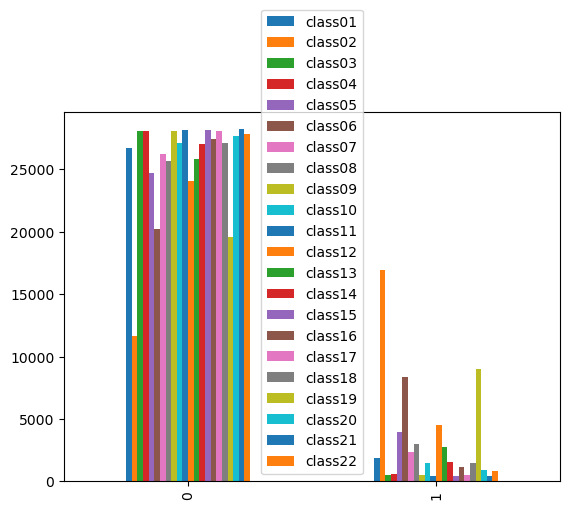

In [35]:
df1 = df[df.columns[500:]]
df2 = df1.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")

In [36]:
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors

In [37]:
import numpy as np

def get_tail_label(data: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = data.sum(axis=0)
    irlbl = irlbl[(irlbl > np.quantile(irlbl,ql[0])) & ((irlbl < np.quantile(irlbl,ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = np.median(irlbl)
    tail_label = pd.Series(irlbl)[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    y_df = pd.DataFrame(y)
    X_df = pd.DataFrame(X)
    tail_labels = get_tail_label(y_df, ql=ql)
    index = y_df[y_df[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X_df[X_df.index.isin(index)].reset_index(drop = True)
    y_sub = y_df[y_df.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [40]:
X = np.asarray(df[df.columns[0:500]])
y = np.asarray(df[df.columns[500:]])

X_sub, y_sub = get_minority_samples(X, y)
X_res, y_res = MLSMOTE(X_sub, y_sub, 100, 5)  # Applying MLSMOTE to augment the dataframe

<AxesSubplot:>

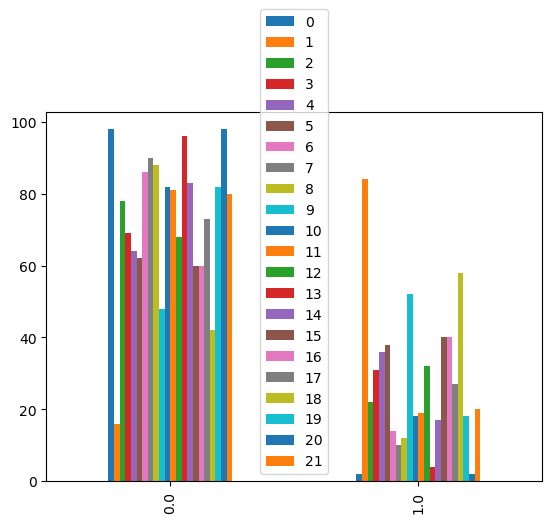

In [41]:
df2 = y_res.apply(pd.value_counts).fillna(0)
df2.plot(kind="bar")



In [42]:
irlbl = y_res.sum(axis=0)
print(irlbl)

0      2.0
1     84.0
2     22.0
3     31.0
4     36.0
5     38.0
6     14.0
7     10.0
8     12.0
9     52.0
10    18.0
11    19.0
12    32.0
13     4.0
14    17.0
15    40.0
16    40.0
17    27.0
18    58.0
19    18.0
20     2.0
21    20.0
dtype: float64
